In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
import collections
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr, SpatialWaves
#from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal

from torch_perturb.perturbations import perturbed

from metrics import top_k_onehot_indicator

2024-09-26 23:52:56.417001: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 23:52:56.471649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 23:52:56.471695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 23:52:56.473081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 23:52:56.482352: I tensorflow/core/platform/cpu_feature_guar

In [2]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000'
exps = glob.glob(base_dir + '/*')
len(exps)

400

In [3]:
def make_report(model, exp, data=None, title=None):
    model.load_state_dict(torch.load(exp + '/model.pth'))
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])

    
    # Make an html page with plots of loss, bpr, nll
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].plot(losses)
    ax[0, 0].set_title('Loss')
    ax[0, 1].plot(bprs)
    ax[0, 1].set_title('BPR')
    ax[1, 0].plot(nlls)
    ax[1, 0].set_title('NLL')
    if data is not None:
        model.plot_learned(data=data, ax=ax[1, 1])
    if title is not None:
        fig.suptitle(title)
    fig.savefig(exp + '/report.png')
    return model
    

In [4]:
exps

['/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init0',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init1',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init10',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init11',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init12',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init13',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_init14',
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.0001_nss50_nps50_ini

In [21]:
max_bpr = 0
best_nll = 100000
for e,exp in enumerate(exps):
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    if bw != '0':
        perturbed_noise = exp.split('sig')[1]
    else:
        perturbed_noise = 'NA'
    ss = exp.split('ss')[1].split('_')[0]
    nss = exp.split('nss')[1].split('_')[0]
    nps = exp.split('nps')[1].split('_')[0]
    #if ss != '0.001':
    #    continue
    #if perturbed_noise != '0.1':
    #    continue
    #if float(perturbed_noise)  < 0.00003:
    #    continue
    #if float(perturbed_noise)  > 0.03:
    #    continue

    #if exp != '/cluster/tufts/hugheslab/kheuto01/large_synth_band_fixk_4000/bw30_nw0_ss0.1_nss200_nps200_sig0.001':
    #    continue

    if e % 10 == 0:
        print(f'Processing {e} / {len(exps)}')

    # extract bw number and new number from model name
    
    title = f'BPR Weight: {bw}, NLL Weight: {nw}, sigma{perturbed_noise}, ss{ss}, nss{nss}, nps{nps}'
    model = SpatialWaves(num_waves=1, low=0, high=100000, has_speed=False)
    model = make_report(model, exp, None, title=title)
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')
    bpr = bprs[-1]
    nll = nlls[-1] 
    if nll < best_nll:
        best_nll = nll
        best_exp_nll = exp
    if bpr>=max_bpr:
        max_bpr = bpr
        best_exp = exp
        

In [22]:
best_nll, best_exp_nll

(tensor(4.5137, dtype=torch.float64),
 '/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.001_nss50_nps50_init12')

In [ ]:
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]
W = 2

In [ ]:
times_by_score = {'50':{'50':[], '100':[], '200':[]}, '100':{'50':[], '100':[], '200':[]}, '200':{'50':[], '100':[], '200':[]}}
for e,exp in enumerate(exps):
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')
    times = torch.load(exp + '/times.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])
    try:
        nss = exp.split('nss')[1].split('_')[0]
        nps = exp.split('nps')[1].split('_')[0]

        mean_time = np.mean(times)
        num= len(times)
        if num>500:
            times_by_score[nss][nps].append(mean_time)
            print(f'Nss: {nss}, Nps: {nps}, Mean Time: {mean_time}, num:{len(times)} exp: {exp}')
    except:
        continue

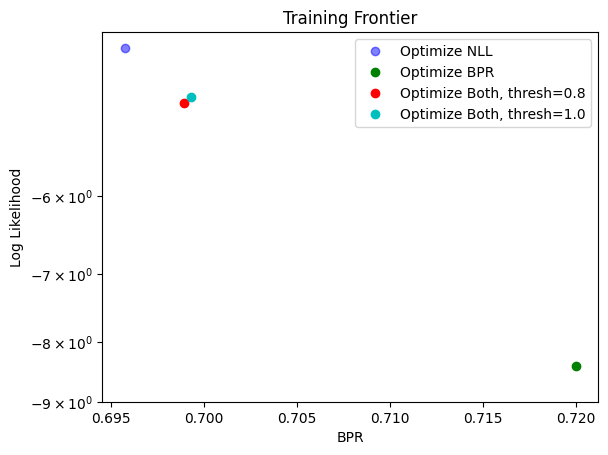

In [5]:
nll_bprs = []
nll_nlls = []
nll_bprs_by_init = -np.inf
nll_nlls_by_init = -np.inf
nll_losses_by_init = np.inf
nll_exp_by_init = collections.defaultdict(str)
bpr_bprs = []
bpr_nlls = []
bpr_bprs_by_init = -np.inf
bpr_nlls_by_init = -np.inf
bpr_losses_by_init = np.inf
bpr_exp_by_init = collections.defaultdict(str)
both_bprs = []
both_nlls = []
both_bprs_by_thresh = collections.defaultdict(lambda: -np.inf)
both_nlls_by_thresh = collections.defaultdict(lambda: -np.inf)
both_losses_by_thresh = collections.defaultdict(lambda: np.inf)
both_exp_by_thresh = collections.defaultdict(lambda: collections.defaultdict(str))
max_nll = -np.inf

for e,exp in enumerate(exps):
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    init = 0
    if 'tr' in exp:
        thresh = float(exp.split('_tr')[-1].split('_')[0])
    else:
        thresh = 0

    bpr = bprs[-1]
    nll = -nlls[-1]
    loss = losses[-1]
    if nll > max_nll:
        max_nll = nll


    if bw=='0':
        nll_bprs.append(bprs[-1])
        nll_nlls.append(-nlls[-1])
        if nll > nll_nlls_by_init:
            nll_nlls_by_init = nll
            nll_bprs_by_init = bpr
            nll_exp_by_init = exp
    elif nw=='0':
        bpr_bprs.append(bprs[-1])
        bpr_nlls.append(-nlls[-1])
        if bpr >= bpr_bprs_by_init:
            if nll > bpr_nlls_by_init:
                bpr_bprs_by_init = bpr
                bpr_nlls_by_init = nll
                bpr_exp_by_init = exp
    else:
        both_bprs.append(bprs[-1])
        both_nlls.append(-nlls[-1])
        if loss < both_losses_by_thresh[thresh]:
            both_bprs_by_thresh[thresh] = bpr
            both_nlls_by_thresh[thresh] = nll
            both_losses_by_thresh[thresh] = loss
            both_exp_by_thresh[thresh] = exp

plt.plot(nll_bprs_by_init, nll_nlls_by_init, 'bo',alpha=0.5, label='Optimize NLL')
plt.plot(bpr_bprs_by_init, bpr_nlls_by_init, 'go', label='Optimize BPR')
# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']

for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh], both_nlls_by_thresh[thresh], f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
# make y ticks at -10, -7.5, -5
plt.yticks([-9, -8, -7, -6,])
plt.title('Training Frontier')
plt.legend()

In [7]:
best_nll_model_path = nll_exp_by_init
best_bpr_model_path = bpr_exp_by_init
best_hybrid_model_path = both_exp_by_thresh[1.0]

In [8]:
print(best_hybrid_model_path)
print(best_bpr_model_path)
print(best_nll_model_path)

/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw30_nw1_ss0.001_nss50_nps50_sig0.001_tr1_init5
/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw30_nw0_ss0.0001_nss50_nps50_sig0.001_init0
/cluster/tufts/hugheslab/kheuto01/large_synth_band_heavysteep_lots_init_100_4000/K100_bw0_nw1_ss0.001_nss50_nps50_init16


In [9]:
best_nll_model = SpatialWaves(num_waves=1, low=0, high=100000)
best_nll_model.load_state_dict(torch.load(best_nll_model_path + '/model.pth'))
best_bpr_model = SpatialWaves(num_waves=1, low=0, high=100000)
best_bpr_model.load_state_dict(torch.load(best_bpr_model_path + '/model.pth'))
best_hybrid_model = SpatialWaves(num_waves=1, low=0, high=100000)
best_hybrid_model.load_state_dict(torch.load(best_hybrid_model_path + '/model.pth'))

<All keys matched successfully>

In [10]:
best_nll_params  = best_nll_model.params_to_single_tensor().detach().numpy()
best_hybrid_params = best_hybrid_model.params_to_single_tensor().detach().numpy()

In [23]:
# interpolate between the two vectors in 100 steps
steps = 100
interpolated_vecs = np.zeros((steps, len(best_nll_params)))
for i in range(steps):
    interpolated_vecs[i] = best_nll_params + (best_hybrid_params - best_nll_params) * i / (steps-1)
    

In [13]:
from functools import partial
data_dir='/cluster/home/kheuto01/code/prob_diff_topk'

step_size=0.1
perturbed_noise=0.0001
K=100
threshold=1
rows=27
cols=60
data_shape=(rows, cols)
deaths = pd.read_csv(os.path.join(data_dir,'deaths_bandheavysteep.csv'))
pop = pd.read_csv(os.path.join(data_dir, 'pop_bandheavysteep.csv'))
num_score_samples = 50
num_pert_samples = 50
bpr_weight=30
nll_weight=0

# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
deaths_TS = torch.tensor(deaths_TS, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


model  = SpatialWaves(num_waves=1,low=0, high=1000000)

optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

M_score_func =  num_score_samples
M_action = M_score_func

top_k_func = partial(top_k_onehot_indicator, k=K)
perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)

In [35]:
def get_grads(model, K, threshold, T,
                           M_score_func, M_action,
                           time_T,pop_S, lat_S, lon_S, train_y_TS,
                           perturbed_top_K_func, bpr_weight, nll_weight, ):

    optimizer.zero_grad()
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)

    def get_log_probs_baked(param):
        distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
        log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

        return log_probs_TMS
    
    jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

    all_sample_tot = ratio_rating_TMS.sum(dim=-2, keepdim=True)
    all_other_sample_mean = (all_sample_tot-ratio_rating_TMS)/(T-1)
    score_func_estimator_TMSP = jac_TMSP * (ratio_rating_TMS - all_other_sample_mean).unsqueeze(-1)
    score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    


    #score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
    #score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

    # get gradient of negative bpr_t  with respect to ratio rating_TS

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
    if nll_weight>0:
        bpr_threshold_diff_T = positive_bpr_T - threshold
        violate_threshold_flag = bpr_threshold_diff_T < 0
        negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
    else:
        negative_bpr_loss = torch.mean(-positive_bpr_T)
    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

    loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    loss.backward()
    loss_grad_TS = ratio_rating_TS.grad

    score_func_grad_P = torch.sum(score_func_estimator_TSP, dim=[0,1]).detach()
 
    gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
    gradient_P = torch.sum(gradient_TSP, dim=[0,1])

    gradient_tuple = model.single_tensor_to_params(gradient_P)

    for param, gradient in zip(model.parameters(), gradient_tuple):
        if nll_weight>0:
            gradient = gradient + param.grad
        param.grad = gradient

    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)

    return [param.grad for param in model.parameters()], [param for param in score_func_grad_P], det_bpr,  positive_bpr_T.mean(), nll

In [ ]:

grads= []
score_grads = []
det_bprs, pert_bprs, nlls = [], [], []
for s in range(steps):
    if s%10 == 0:
        print(s)
    model.update_params(torch.tensor(interpolated_vecs[s], dtype=torch.float32))
    grad, score_grad, det_bpr, pert_bpr, nll = get_grads(model, K, threshold, T,
                                        M_score_func, M_action,time_T,pop_S,
                                        lat_S, lon_S, deaths_TS, 
                                        perturbed_top_K_func, bpr_weight, 
                                        nll_weight)
    grads.append(grad)
    score_grads.append(score_grad)
    det_bprs.append(det_bpr)
    pert_bprs.append(pert_bpr)
    nlls.append(nll)

In [11]:
plt.plot(det_bprs, label='deterministic BPR')
plt.title('deterministic_bpr')
#plt.ylim([0.1,0.3])
plt.show()
plt.plot([bpr.detach() for bpr in pert_bprs], label='perturbed BPR')
plt.title('perturbed_bpr')
#plt.ylim([0.1,0.3])
plt.show()
plt.plot([nll.detach() for nll in nlls], label='NLL')
plt.title('NLL')
plt.show()

NameError: name 'det_bprs' is not defined

In [25]:
nll_dist = best_nll_model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = nll_dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
best_nll_r =  ratio_rating_TMS.mean(dim=1)

torch.Size([52, 1620, 1])


In [26]:
hybrid_dist = best_hybrid_model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = hybrid_dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
best_hybrid_r =  ratio_rating_TMS.mean(dim=1)

torch.Size([52, 1620, 1])


In [27]:
bpr_dist = best_bpr_model(time_T,pop_S, lat_S, lon_S)

y_sample_TMS = bpr_dist.sample((M_score_func,)).permute(1, 0, 2)
y_sample_action_TMS = y_sample_TMS

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
best_bpr_r =  ratio_rating_TMS.mean(dim=1)

torch.Size([52, 1620, 1])


Text(0.5, 1.0, 'Data at T=20')

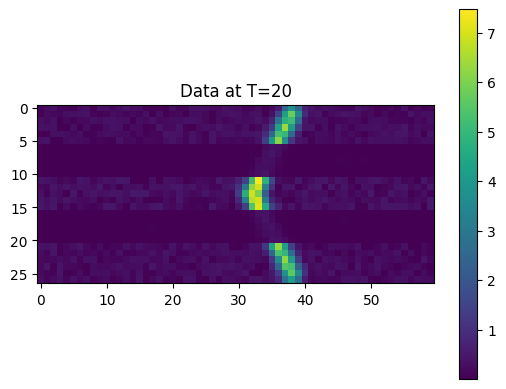

In [28]:
plt.imshow(deaths_TS[20,:].reshape(data_shape))
plt.colorbar()
plt.title(f'Data at T=20')

In [58]:
deaths_TS[20,:]

tensor([0.1076, 0.2505, 0.3347,  ..., 0.2691, 0.2342, 0.2178])

In [63]:
deterministic_bpr(best_nll_r, deaths_TS, K=K)

tensor([0.6909, 0.7043, 0.6964, 0.6975, 0.6923, 0.6909, 0.6939, 0.6917, 0.6973,
        0.6941, 0.6943, 0.7005, 0.6970, 0.6943, 0.6985, 0.6944, 0.6884, 0.7004,
        0.7022, 0.6937, 0.6960, 0.6877, 0.6936, 0.6956, 0.6861, 0.6988, 0.7002,
        0.6964, 0.6995, 0.6983, 0.6952, 0.6937, 0.6954, 0.6894, 0.6890, 0.6817,
        0.6913, 0.6939, 0.6988, 0.6939, 0.6949, 0.6912, 0.6944, 0.6977, 0.7017,
        0.7003, 0.6977, 0.7003, 0.6951, 0.7047, 0.7041, 0.7027])

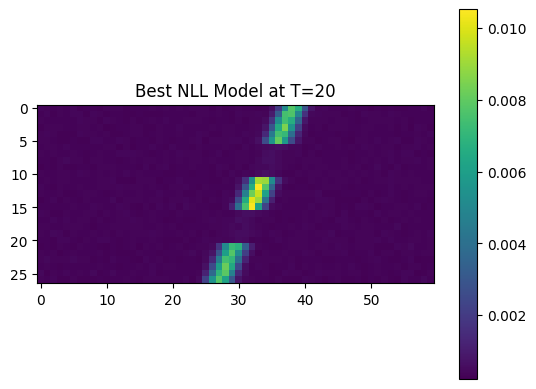

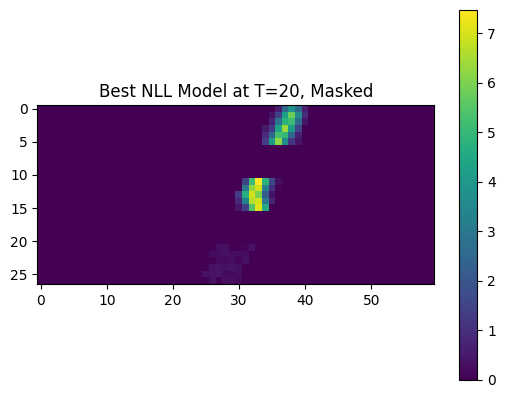

tensor(0.0025)

In [44]:
best_nll_vals = best_nll_r.detach().numpy()[20,:].reshape(27,60)
plt.imshow(best_nll_vals)
plt.colorbar()
plt.title(f'Best NLL Model at T=20')
plt.show()
# show image of mask of  top  100 values in best_nll
mask = np.zeros((27,60))
mask[np.unravel_index(np.argsort(best_nll_vals.ravel())[-100:], data_shape)] = 1
plt.imshow(mask*deaths_TS[20,:].reshape(data_shape).detach().numpy())
plt.colorbar()
plt.title(f'Best NLL Model at T=20, Masked')
plt.show()

(mask*deaths_TS[20,:].reshape(data_shape).detach().numpy()).sum()/


Text(0.5, 1.0, 'Best Hybrid Model at T=20')

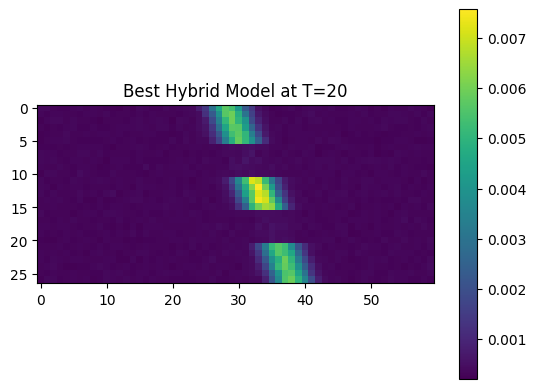

In [30]:
plt.imshow(best_hybrid_r.detach().numpy()[20,:].reshape(27,60))
plt.colorbar()
plt.title(f'Best Hybrid Model at T=20')

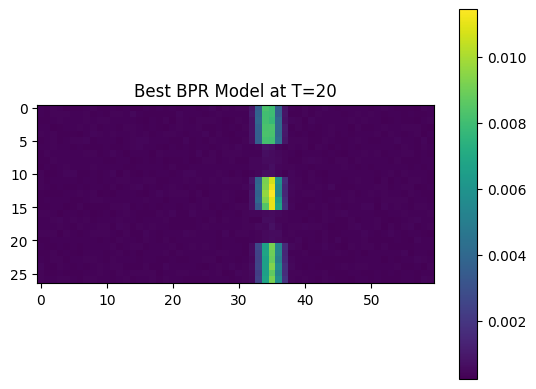

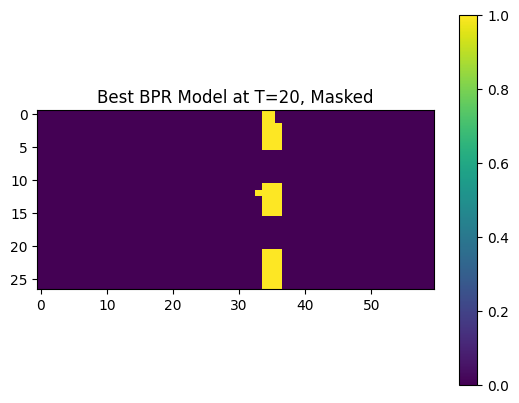

In [62]:
best_bpr_vals = best_bpr_r.detach().numpy()[20,:].reshape(27,60)
plt.imshow(best_bpr_vals)
plt.colorbar()
plt.title(f'Best BPR Model at T=20')
plt.show()
mask = np.zeros((27,60))
mask[np.unravel_index(np.argsort(best_bpr_vals.ravel())[-50:], data_shape)] = 1
plt.imshow(mask)
plt.colorbar()
plt.title(f'Best BPR Model at T=20, Masked')
plt.show()


In [20]:
# print to 2 decimal places with param names
names = ['arrival_speeds', 'arrival_intercepts', 'lat_coeff', 'lon_coeff', 'softinv magnitude', 'softinv width']

for name, param in zip(names, best_nll_params):
    print(f'{name}: {param:.2f}')  

arrival_speeds: 23.15
arrival_intercepts: -0.98
lat_coeff: -0.41
lon_coeff: -5.37
softinv magnitude: 1.57


In [ ]:
for name, param in zip(names, best_hybrid_params):
    print(f'{name}: {param:.2f}')  